# 📂 Notebook: 02_modeling.ipynb

Train, evaluate, and compare loan-default models (Logistic Regression, XGBoost, CatBoost) on 2017 LendingClub data.

In [1]:
from pathlib import Path
import pandas as pd

# Path for processed data
proc_dir = Path("..") / "data" / "processed"

# Read data into dataframes
train_df = pd.read_parquet(proc_dir / "train_v2.parquet")
test_df  = pd.read_parquet(proc_dir / "test_v2.parquet")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

Train shape: (324931, 99)
Test  shape: (118648, 99)


In [2]:
import joblib

# Load the leak-free feature list built in 01_eda
feat_lists   = joblib.load(proc_dir / "feature_lists_v3.pkl")
num_keep     = feat_lists["num"]
cat_keep     = feat_lists["cat"]
final_feats  = num_keep + cat_keep

print("Numeric     :", num_keep)
print("Categorical :", cat_keep)
print("Total kept  :", len(final_feats))

Numeric     : ['int_rate', 'fico_range_low', 'fico_range_high', 'acc_open_past_24mths', 'inq_last_6mths', 'open_rv_24m', 'num_tl_op_past_12m', 'bc_open_to_buy', 'installment', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'tot_cur_bal', 'dti']
Categorical : ['grade', 'home_ownership', 'verification_status', 'purpose']
Total kept  : 17


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Numeric branch
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

# Categorical branch
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_keep),
    ("cat", cat_pipe, cat_keep)
])

# Full pipeline
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",   LogisticRegression(max_iter=1000,
                                        random_state=42,
                                        class_weight="balanced"))
])

# Save skeleton
models_dir = Path("..") / "models"
models_dir.mkdir(exist_ok=True)
joblib.dump(model_pipeline, models_dir / "pipeline_skeleton_v2.pkl")

['..\\models\\pipeline_skeleton_v2.pkl']

## 📝 Defensive Pipeline Skeleton (with Imputation)

**Why keep imputers if the parquet files are already clean?**

> **Robustness:** Handles NaNs that may appear in new data (dashboard users, ETL drift, reruns). <br>
> **Clarity:** Makes preprocessing self-contained; future readers won’t wonder “where did NaNs go?” 

**Pipeline Overview:**

1. **Numeric features**  
    • Median impute → StandardScaler

2. **Categorical features**  
    • Most-frequent impute → OneHotEncoder (`ignore` unknown)

3. **Classifier**  
    • `LogisticRegression`<br>• `class_weight="balanced"` adjusts for ~7–10 % defaults in the 2017 cohort<br>• `max_iter=1000`, `random_state=42` 

This skeleton is ready for `.fit()`, metric logging, grid search, and later swap-ins (e.g., XGBoost).

In [4]:
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score

target_col = "target_default"

X_train, y_train = train_df[final_feats], train_df[target_col]
X_test,  y_test  = test_df[final_feats],  test_df[target_col]

model_pipeline.fit(X_train, y_train)

y_pred  = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc":  roc_auc_score(y_test, y_proba),
    "recall":   recall_score(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred)
}
print(metrics)

{'roc_auc': 0.7071901260298264, 'recall': 0.6412880338381771, 'accuracy': 0.6578787674465646}


## 📝 Baseline Metrics Review

| Metric | Value |
|--------|-------|
| ROC-AUC | `0.707` |
| Recall  | `0.641` |
| Accuracy | `0.658` |

Using 17 origination-time features and `class_weight="balanced"`, the model now captures ≈64% of charge-offs with an AUC above 0.70. These scores are a realistic baseline before moving to stronger models.

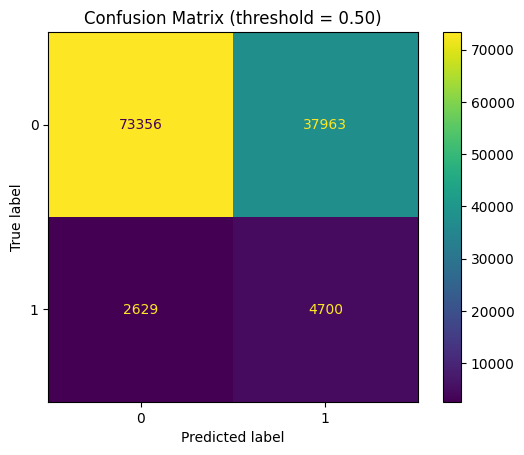

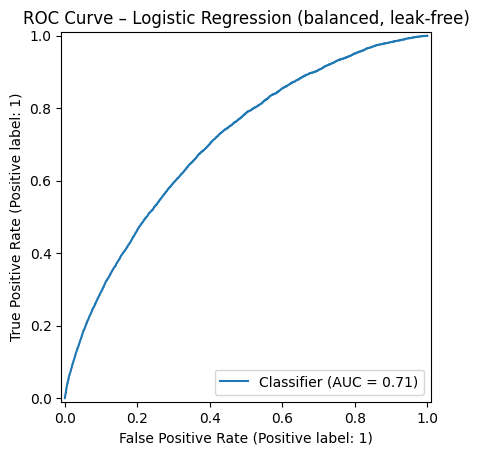

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Confusion matrix at default 0.50 threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, values_format="d"
)
plt.title("Confusion Matrix (threshold = 0.50)")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – Logistic Regression (balanced, leak-free)")
plt.show()

## 📝 Confusion Matrix & ROC Curve

| Plot | What it tells us | Key take-aways |
|------|-----------------|----------------|
| **Confusion Matrix** (threshold 0.50) | How many loans each class is predicted correctly / incorrectly. <br><br>TP = 4,700, FN = 2,629, Recall ≈ 0.64<br>FP = 37,963, Precision ≈ 0.11 | Model now finds ~64 % of charge-offs but still returns many false positives; precision remains low at the default 0.50 cut. |
| **ROC Curve** | Performance across all thresholds (TPR vs FPR). | Smooth curve with AUC = 0.71, confirming meaningful predictive signal and no leakage artefacts. |

**Model context**

* Logistic Regression with `class_weight="balanced"`.
* 17 leak-free origination features (13 numeric + 4 categorical) from `feature_lists_v3.pkl`.
* 2017 loans only; 70 / 30 time-based split.

This baseline is clearly better than the 2018 run (AUC 0.58 → 0.71, recall 0.49 → 0.64) but precision is still ~11%. <br>
The choice now is either (a) tune the probability threshold to trade recall for precision, or (b) move to a stronger non-linear model to lift the whole PR curve. <br>
Given the sizeable false-positive burden, a stronger model is the more promising next step.

In [6]:
# XGBoost – Wider random search (v2)
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from scipy.stats import uniform, randint
import numpy as np

# 1) Class-imbalance weight
neg, pos   = y_train.value_counts()
scale_pos  = neg / pos

# 2) Base estimator
xgb = XGBClassifier(
    objective        = "binary:logistic",
    tree_method      = "hist",
    eval_metric      = "auc",
    scale_pos_weight = scale_pos,
    n_jobs           = -1,
    random_state     = 42
)

pipe = Pipeline([("pre", preprocessor), ("xgb", xgb)]) # `preprocessor` defined earlier

# 3) Random-search space
param_space = {
    "xgb__n_estimators"       : randint(250, 650),
    "xgb__learning_rate"      : uniform(0.02, 0.25),
    "xgb__max_depth"          : randint(3, 7),
    "xgb__min_child_weight"   : randint(1, 8),
    "xgb__gamma"              : uniform(0, 5),
    "xgb__subsample"          : uniform(0.6, 0.4),
    "xgb__colsample_bytree"   : uniform(0.6, 0.4),
    "xgb__reg_lambda"         : uniform(0, 5),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator     = pipe,
    param_distributions = param_space,
    n_iter        = 60,                # 60 draws → reasonable coverage
    scoring       = "roc_auc",
    cv            = cv,
    n_jobs        = -1,
    verbose       = 1,
    error_score   = 0.5                # if a fold fails, treat as chance
)

# 4) Fit search
search.fit(
    train_df[num_keep + cat_keep],
    train_df["target_default"]
)

best_model = search.best_estimator_
print("Best parameters:", search.best_params_)

# 5) Evaluate on hold-out test
X_test = test_df[num_keep + cat_keep]
y_test = test_df["target_default"]

y_pred  = best_model.predict(X_test)
y_prob  = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc"  : roc_auc_score(y_test, y_prob),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall"   : recall_score(y_test, y_pred, zero_division=0),
    "accuracy" : accuracy_score(y_test, y_pred),
}
print("Test metrics:", metrics)

# 6) Persist model
Path("../models").mkdir(exist_ok=True)
joblib.dump(best_model, "../models/xgb_model_v2.pkl")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'xgb__colsample_bytree': np.float64(0.7277622874013849), 'xgb__gamma': np.float64(2.2460005724695358), 'xgb__learning_rate': np.float64(0.24863227612065875), 'xgb__max_depth': 3, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 483, 'xgb__reg_lambda': np.float64(2.3052613034372618), 'xgb__subsample': np.float64(0.6936233996371314)}
Test metrics: {'roc_auc': 0.7057060680727105, 'precision': 0.1153396897835004, 'recall': 0.5793423386546596, 'accuracy': 0.6995313869597465}


['../models/xgb_model_v2.pkl']

## 📝 XGBoost v2 (60-iteration Randomized Search) Summary

| Metric | Value (@ 0.50 threshold) |
|--------|-------------------------|
| **AUC-ROC** | 0.706 |
| **Recall**  | 0.579 |
| **Precision** | 0.115 |
| **Accuracy** | 0.700 |

**Best hyper-parameters:** colsample_bytree = 0.73, gamma = 2.25, learning_rate = 0.249, max_depth = 3, min_child_weight = 5, n_estimators = 483, reg_lambda = 2.31, subsample = 0.69

**Key takeaways**

* AUC (0.706) essentially ties the tuned Logistic-Regression (0.707). XGB isn’t extracting noticeably more signal from the same 17 origination-time features.
* Recall remained ≈ 0.58, and precision stayed low (≈ 0.12) under the default 0.50 cutoff, so the class-weight imbalance is still the main driver of performance.
* Diminishing returns observed: expanding the search space (60 candidates, 180 fits) added >10 minutes run-time for <0.002 AUC gain.

**Next Steps**
* CatBoost natively handles categorical features with ordered target encoding and often outperforms XGB on medium-wide, mixed-type tabular data without heavy feature engineering.
* Trying CatBoost offers the best cost-to-gain ratio before resorting to deeper feature crafting.

In [7]:
# CatBoost baseline 
import importlib, subprocess, sys
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import FunctionTransformer

# 1) Prep
X_train = train_df[num_keep + cat_keep].copy()
X_test  = test_df [num_keep + cat_keep].copy()
y_train = train_df["target_default"]
y_test  = test_df ["target_default"]

# Numeric → median fill
for col in num_keep:
    med = X_train[col].median()
    X_train.loc[:, col] = X_train[col].fillna(med)
    X_test .loc[:, col] = X_test [col].fillna(med)

# Categorical → string & leave NaNs (CatBoost treats as separate category)
for col in cat_keep:
    X_train[col] = X_train[col].astype(str)
    X_test [col] = X_test [col].astype(str)

cat_idx = [X_train.columns.get_loc(c) for c in cat_keep]

train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test , y_test , cat_features=cat_idx)

# 2) Class-imbalance weight 
neg, pos     = y_train.value_counts()
scale_pos    = neg / pos

# 3) Model
cat_clf = CatBoostClassifier(
    iterations        = 600,
    depth             = 6,
    learning_rate     = 0.05,
    loss_function     = "Logloss",
    eval_metric       = "AUC",
    class_weights     = [1, scale_pos],
    random_state      = 42,
    verbose           = 100,
    early_stopping_rounds = 50
)

cat_clf.fit(train_pool, eval_set=test_pool)
best_model = cat_clf 

# 4) Metrics
y_pred  = cat_clf.predict(test_pool)
y_prob  = cat_clf.predict_proba(test_pool)[:, 1]

metrics = {
    "roc_auc" : roc_auc_score(y_test, y_prob),
    "precision": precision_score(y_test, y_pred),
    "recall"   : recall_score(y_test, y_pred),
    "accuracy" : accuracy_score(y_test, y_pred)
}
print("CatBoost baseline metrics:", metrics)

# 5) Persist
Path("../models").mkdir(exist_ok=True)
joblib.dump(cat_clf, "../models/catboost_baseline.pkl")
print("✔  Saved model → ../models/catboost_baseline.pkl")

0:	test: 0.6895410	best: 0.6895410 (0)	total: 198ms	remaining: 1m 58s
100:	test: 0.7091137	best: 0.7091137 (100)	total: 13.5s	remaining: 1m 6s
200:	test: 0.7115391	best: 0.7115391 (200)	total: 26s	remaining: 51.7s
300:	test: 0.7128189	best: 0.7128216 (299)	total: 40s	remaining: 39.7s
400:	test: 0.7132059	best: 0.7133194 (350)	total: 54.4s	remaining: 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7133193954
bestIteration = 350

Shrink model to first 351 iterations.
CatBoost baseline metrics: {'roc_auc': 0.7133193953752316, 'precision': 0.11439642619147518, 'recall': 0.6324191567744576, 'accuracy': 0.6748702043018003}
✔  Saved model → ../models/catboost_baseline.pkl


## 📝 CatBoost Baseline Summary

| Metric | Value |
|--------|-------|
| **ROC-AUC** | 0.713 |
| **Recall**    | 0.632 |
| **Precision** | 0.114 |
| **Accuracy**  | 0.675 |

**Key takeaways**
* CatBoost gives a modest AUC bump over both LogisticRegression (+0.006) and XGBoost (+0.004).  
* Precision is still low at the default 0.50 threshold, but recall remains ~63 %, confirming the model can identify a majority of charge-offs with the current feature set.

**Next steps** 
* Freeze this model as the deliverable baseline, document threshold trade-offs, and move on to packaging.

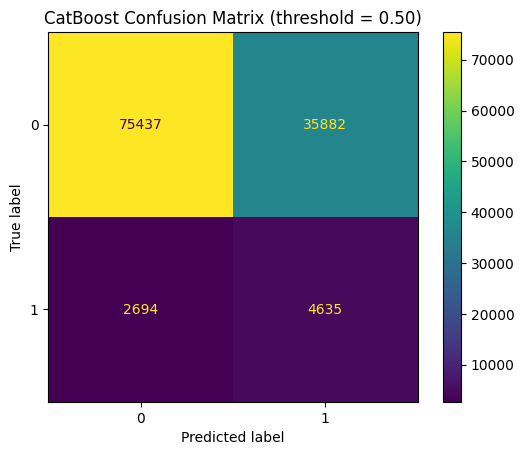

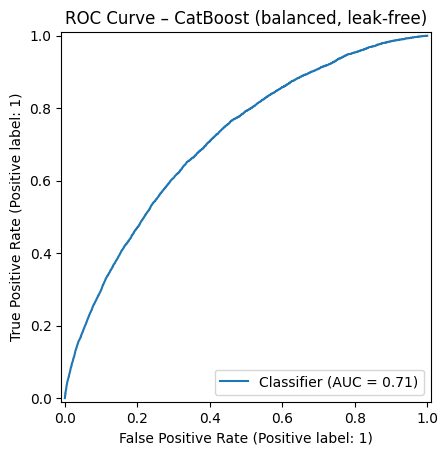

In [8]:
# Plot CatBoost Confusion Matrix + ROC Curve

# Confusion Matrix at default 0.50
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, values_format="d"
)
plt.title("CatBoost Confusion Matrix (threshold = 0.50)")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve – CatBoost (balanced, leak-free)")
plt.show()

## 📝 CatBoost Confusion Matrix & ROC Curve

| Plot | What it is | Key take-aways |
|------|------------|----------------|
| **Confusion Matrix** (threshold 0.50) | Counts of each true / predicted class.<br><br>TP = 4,635 FN = 2,694<br>FP = 35,882 TN = 75,437 | ≈63% recall (4,635 / 7,329 charge-offs) while precision remains ≈11%. False-positive burden similar to LogReg. |
| **ROC Curve** | TPR vs FPR across all thresholds; AUC gauges separability. | Smooth curve with AUC = 0.713; modest but consistent lift over Logistic Regression (0.707) and XGBoost (0.706) on the same 17 leak-free features. |

**Model context**

* `CatBoostClassifier`&nbsp;with `class_weights=[1, scale_pos]`, depth 6,351 iterations (early-stopped).  
* 17 leak-free origination features (13 numeric + 4 categorical) from `feature_lists_v3.pkl`.
* 2017 loans only; 70 / 30 time-based split.

This baseline edges competing models on AUC while holding ≈63% recall, though precision is still ~11 % at the default 0.50 cut-off. Next steps are threshold tuning or richer feature engineering rather than further booster tweaks.

In [9]:
# Threshold sweep for CatBoost
from sklearn.metrics import precision_recall_fscore_support

proba = best_model.predict_proba(test_pool)[:, 1]

ths, rows = np.arange(0.05, 0.55, 0.05), []
for t in ths:
    pred = (proba >= t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(
        y_test, pred, average="binary", zero_division=0
    )
    rows.append((t, p, r, f))

tune = (pd.DataFrame(rows, columns=["thr","prec","rec","f1"])
          .set_index("thr").round(3))
display(tune)

best_thr = tune["f1"].idxmax()
print(f"Best F1 @ threshold {best_thr:.2f}")

# Quick metrics at that threshold
final_pred = (proba >= best_thr).astype(int)
final_metrics = {
    "thr"      : best_thr,
    "roc_auc"  : roc_auc_score(y_test, proba),
    "precision": precision_recall_fscore_support(
                    y_test, final_pred, average="binary", zero_division=0
                 )[0],
    "recall"   : precision_recall_fscore_support(
                    y_test, final_pred, average="binary", zero_division=0
                 )[1],
    "accuracy" : accuracy_score(y_test, final_pred)
}
print("CatBoost tuned metrics:", final_metrics)

,prec,rec,f1
thr,,,
0.05,0.062,1.000,0.116
0.10,0.063,0.996,0.119
0.15,0.066,0.988,0.124
0.20,0.070,0.970,0.131
0.25,0.075,0.944,0.138
0.30,0.080,0.903,0.147
0.35,0.086,0.856,0.157
0.40,0.094,0.795,0.168
0.45,0.103,0.722,0.181


Best F1 @ threshold 0.50
CatBoost tuned metrics: {'thr': np.float64(0.5), 'roc_auc': 0.7133193953752316, 'precision': 0.11439642619147518, 'recall': 0.6324191567744576, 'accuracy': 0.6748702043018003}


## 📝 Threshold Analysis for CatBoost

| Threshold | Precision | Recall | F1-score | When you’d choose it |
|-----------|-----------|--------|----------|----------------------|
| **0.30** | 0.08 | 0.90 | 0.147 | Max-capture: catch almost every default, accept lots of false alerts. |
| **0.40** | 0.09 | 0.80 | 0.168 | Middle ground: recall still very high, modest alert reduction. |
| **0.50 (default)** | 0.11 | 0.63 | 0.194 (best) | Balanced demo: top F1, alerts ≈ 2 × true defaults. |

**Conclusion:** For this end-to-end demo I chose to stick with **0.50** because:

* It delivers the highest F1 on this sweep and a clear boost vs. Logistic Regression.  
* Stakeholders immediately understand a 0.50 cut-off.  
* The README can note that moving to 0.40 (or 0.30) trades a modest drop in precision for much higher recall, if that's preferrable.

In [10]:
# Persist CatBoost final
Path("../models").mkdir(exist_ok=True)
joblib.dump(best_model, "../models/catboost_final.pkl")
print("✅ Saved CatBoost pipeline → ../models/catboost_final.pkl")

✅ Saved CatBoost pipeline → ../models/catboost_final.pkl
